In [1]:
import torch
torch.__version__

'2.4.1+cu118'

In [2]:
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
import random

### function to preprocess the corpus

In [3]:
def preprocess_corpus(corpus_file, context_size):
    with open(corpus_file, 'r') as f:
        text = f.read().lower().split() 

    vocab = set(text)
    word_to_ix = {word: i for i, word in enumerate(vocab)}
    ix_to_word = {i: word for word, i in word_to_ix.items()}
    
    data = []
    for i in range(context_size, len(text) - context_size):
        context = [word_to_ix[text[i - j]] for j in range(context_size, 0, -1)]
        target = word_to_ix[text[i]]
        data.append((context, target))

    return data, word_to_ix, ix_to_word

### neural probalistic language model

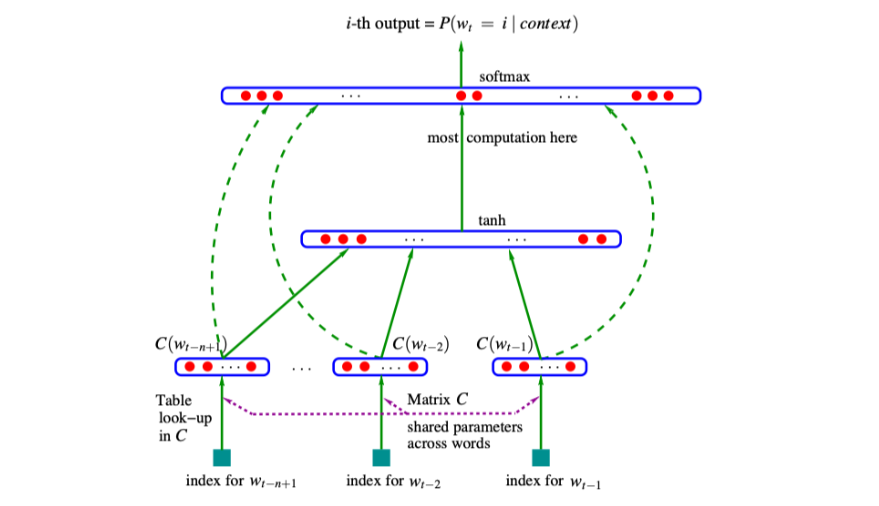

In [4]:
class NPLM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(NPLM, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.tanh = nn.Tanh()

    def forward(self, inputs):
        context_size = inputs.size(0)  
        flattened_input_size = context_size * self.embedding_dim
        
        embeds = self.embeddings(inputs).view(1, -1)  

        linear1 = nn.Linear(flattened_input_size, self.hidden_dim).to(inputs.device)
        linear2 = nn.Linear(self.hidden_dim, self.vocab_size).to(inputs.device)

        out = linear1(embeds)
        out = self.tanh(out)
        
        #log probs for PDF
        log_probs = torch.log_softmax(linear2(out), dim=1)
        
        return log_probs

### train function

In [5]:
def train(model, data, epochs, lr=0.001):
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for context, target in data:
            context_tensor = torch.tensor(context, dtype=torch.long).to(device="cuda")
            target_tensor = torch.tensor([target], dtype=torch.long).to(device="cuda")

            model.zero_grad()

            log_probs = model(context_tensor)

            loss = loss_function(log_probs, target_tensor)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(data):.4f}")

### hyperparameters

In [6]:
context_size = 3
embedding_dim = 100
hidden_dim = 256
epochs = 100
learning_rate = 0.001

### getting the vocab size

In [7]:
data, word_to_ix, ix_to_word = preprocess_corpus("corpus.txt", context_size)
vocab_size = len(word_to_ix)

In [8]:
vocab_size

425

In [9]:
model = NPLM(vocab_size, embedding_dim, hidden_dim)

In [10]:
model.to(device="cuda")

NPLM(
  (embeddings): Embedding(425, 100)
  (tanh): Tanh()
)

In [11]:
train(model, data, epochs, learning_rate)

Epoch 1/100, Loss: 6.0854
Epoch 2/100, Loss: 6.0912
Epoch 3/100, Loss: 6.0996
Epoch 4/100, Loss: 6.0798
Epoch 5/100, Loss: 6.0811
Epoch 6/100, Loss: 6.0720
Epoch 7/100, Loss: 6.1007
Epoch 8/100, Loss: 6.0890
Epoch 9/100, Loss: 6.0778
Epoch 10/100, Loss: 6.0765
Epoch 11/100, Loss: 6.0763
Epoch 12/100, Loss: 6.1036
Epoch 13/100, Loss: 6.0817
Epoch 14/100, Loss: 6.0867
Epoch 15/100, Loss: 6.0939
Epoch 16/100, Loss: 6.0706
Epoch 17/100, Loss: 6.0876
Epoch 18/100, Loss: 6.0835
Epoch 19/100, Loss: 6.0965
Epoch 20/100, Loss: 6.0798
Epoch 21/100, Loss: 6.0989
Epoch 22/100, Loss: 6.0884
Epoch 23/100, Loss: 6.1073
Epoch 24/100, Loss: 6.0819
Epoch 25/100, Loss: 6.0769
Epoch 26/100, Loss: 6.0872
Epoch 27/100, Loss: 6.0791
Epoch 28/100, Loss: 6.1031
Epoch 29/100, Loss: 6.0765
Epoch 30/100, Loss: 6.0902
Epoch 31/100, Loss: 6.0836
Epoch 32/100, Loss: 6.0979
Epoch 33/100, Loss: 6.0896
Epoch 34/100, Loss: 6.1096
Epoch 35/100, Loss: 6.1032
Epoch 36/100, Loss: 6.0848
Epoch 37/100, Loss: 6.0947
Epoch 38/1

### prediction function

In [12]:
def predict_next_word(model, context, ix_to_word, top_k=2):
    context_tensor = torch.tensor(context, dtype=torch.long).to(device="cuda")
    with torch.no_grad():
        log_probs = model(context_tensor)
        probs = torch.exp(log_probs)
        top_probs, top_indices = torch.topk(probs, top_k)
        predictions = [(ix_to_word[idx.item()], prob.item()) for idx, prob in zip(top_indices[0], top_probs[0])]
    return predictions

### testing

In [24]:
context_words = ["India", "is", "a"]
context = [word_to_ix[word] for word in context_words if word in word_to_ix]

predictions = predict_next_word(model, context, ix_to_word)
print("Predictions:", predictions)

Predictions: [('hindu', 0.005308751482516527), ('zoroastrianism', 0.005142100155353546)]
